In [1]:
import torch
import numpy as np
from torchvision.datasets import MNIST
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from IPython.display import clear_output
import torch.nn as nn
from torch.optim import Adam
from typing import Tuple, List
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = 'max_split_size_mb:256'

In [2]:
train_transforms = T.Compose(
    [
        T.RandomCrop(32, padding=4, padding_mode='reflect'),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean=[0.49139968, 0.48215841, 0.44653091], std=[0.24703223, 0.24348513, 0.26158784])
    ])

In [3]:
test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=[0.49139968, 0.48215841, 0.44653091], std=[0.24703223, 0.24348513, 0.26158784])
    ])

In [4]:
train_dataset = CIFAR10('../datasets/cifar10', download=True, train=True, transform=train_transforms)
valid_dataset = CIFAR10('../datasets/cifar10', download=True, train=False, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=20, shuffle=False, num_workers=2, pin_memory=True)

In [6]:
def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [7]:
@torch.inference_mode()
def evaluate(model, loader) -> Tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [8]:
from IPython.display import clear_output

def plot_stats(
    train_loss: List,
    valid_loss: List,
    train_accuracy: List,
    valid_accuracy: List,
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [9]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        if valid_accuracy >= 0.905:

            break

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        
        print(valid_accuracy_history)
        print('completed sucessfully')

In [10]:
class FourthModel(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        ###  3 канала -> 32
        self.block1 = nn.Sequential(nn.Conv2d(in_channels=3, 
                                              out_channels=32,
                                              kernel_size=3, 
                                              padding=1),  
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        ### картинка 32 на 32 канала -> 32 канала 
        self.block2 = nn.Sequential(nn.Conv2d(in_channels=32, 
                                              out_channels=32,
                                              kernel_size=3, 
                                              padding=1),  # 32 x 32 x 32
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())  
        
        ### в block3 - 32 канала, далее в nn.MaxPool2d(2) 
        ### т.к. MaxPool2d = 2, 32/2 = 16, -> картинка 16 на 16 на 64 канала
        ### 16 x 16 т.к. MaxPool2d 
        self.block3 = nn.Sequential(
            nn.MaxPool2d(2), nn.Conv2d(in_channels=32, 
                                       out_channels=64,
                                       kernel_size=3, 
                                       padding=1),  
            # 16 x 16 x 64
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        ### далее хотим увеличить число каналов с 32 до 64, 
        ### из-за разности матриц на блоке 3 и 4 сделаем переходную матрицу 64 на 64
        self.block4 = nn.Sequential(nn.Conv2d(in_channels=64, 
                                              out_channels=64,
                                              kernel_size=3, 
                                              padding=1),  #16x16x ?64?
                                    nn.BatchNorm2d(64),
                                    nn.ReLU()) 
        
        ### зашла картинка 16 на 16 и со 64 каналами, вышло 128 каналов
        self.block5 = nn.Sequential(nn.Conv2d(in_channels=64, 
                                              out_channels=128,
                                              kernel_size=3, 
                                              padding=1), #16x16x ?128?
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        ### далее мы хотим увеличить число каналов с 64 до 128, 
        ### но сделать это сразу нельзя из-за разности матриц на блоке 5 и 6
        ### для этого сделаем переходную матрицу 128 на 128
        self.block6 = nn.Sequential(nn.Conv2d(
            in_channels=128, 
            out_channels=128,
            kernel_size=3, 
            padding=1)) #16x16x ?128?
        
        ### nn.MaxPool2d(2) т.к. MaxPool2d = 2, 16/2 = 8)
        ### в block7 зашла картинка 8 на 8 каналов и 128 фильтров 
        self.block7 = nn.Sequential(nn.MaxPool2d(2), nn.Conv2d(
            in_channels=128, 
            out_channels=128,
            kernel_size=3, 
            padding=1))  #8x8x128
        
        ### nn.MaxPool2d(2) т.к. MaxPool2d = 2, 8/2 = 4)
        ### далее в Sequential, вышла картинка 4 на 4 каналов и 128 фильтров 
        self.block8 = nn.Sequential(nn.MaxPool2d(2), nn.Conv2d(
            in_channels=128, 
            out_channels=128,
            kernel_size=3, 
            padding=1)) #4x4x128
                                    
        ### вытягиваем 4 на 4 на 128 в вектор = 2048                           
        self.block9 = nn.Sequential(nn.Flatten())
        
        ### передаем уже в полносвязаный слой на вход nn.Linear 4 на 4 на 128, 
        ### а на выходе получаем 512 
        ### далее нормализуем выход 512
        ### рандомно выключаем нейроны (чтобы не переобучится)
        ### применеема функцию активации
        ### получаем последный на вход 512, а на выход 10 
        self.block10 = nn.Sequential(
            nn.Linear(4 * 4 * 128, 512),
            nn.Dropout(p=0.3),
            nn.Linear(512, 10))

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x) + x
        x = self.block3(x)
        x = self.block4(x) + x
        x = self.block5(x) 
        x = self.block6(x) + x
        x = self.block7(x) 
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        
        return x

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
# print(torch.cuda.get_device_name())

cuda:0


In [12]:
loss_fn = nn.CrossEntropyLoss()

model = FourthModel().to(device)

optimizer = Adam(model.parameters(),
                 lr=1e-3)

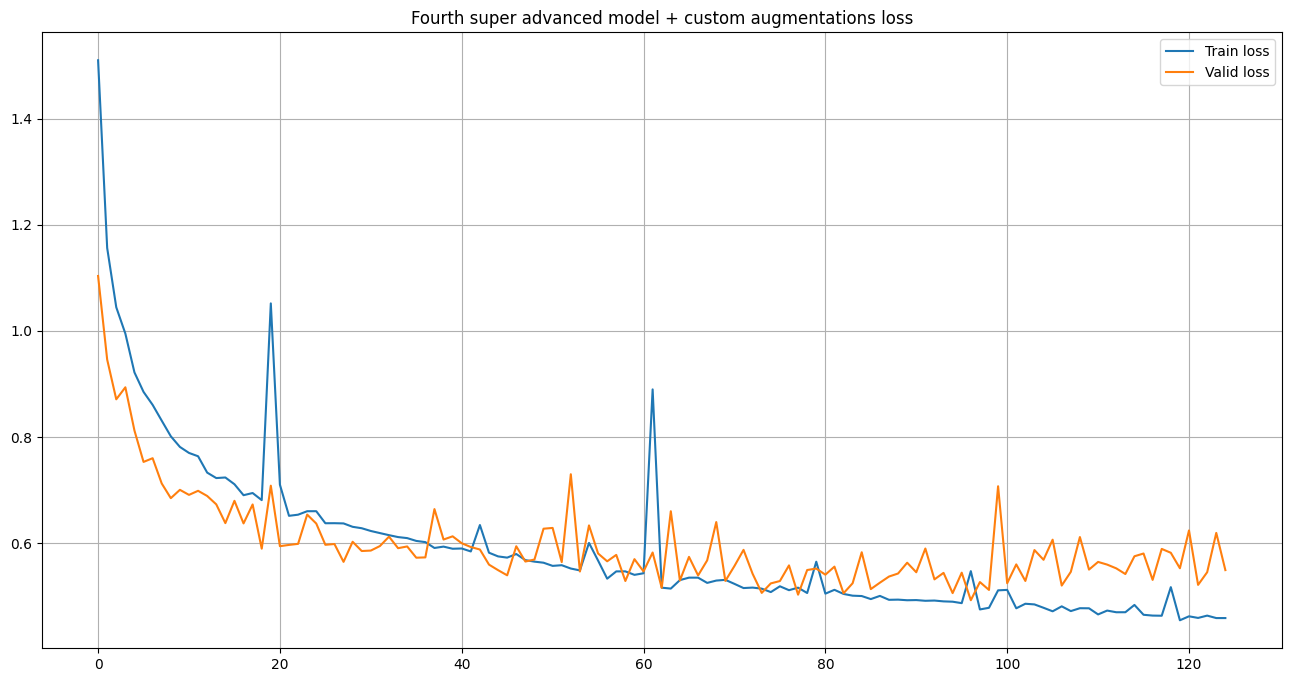

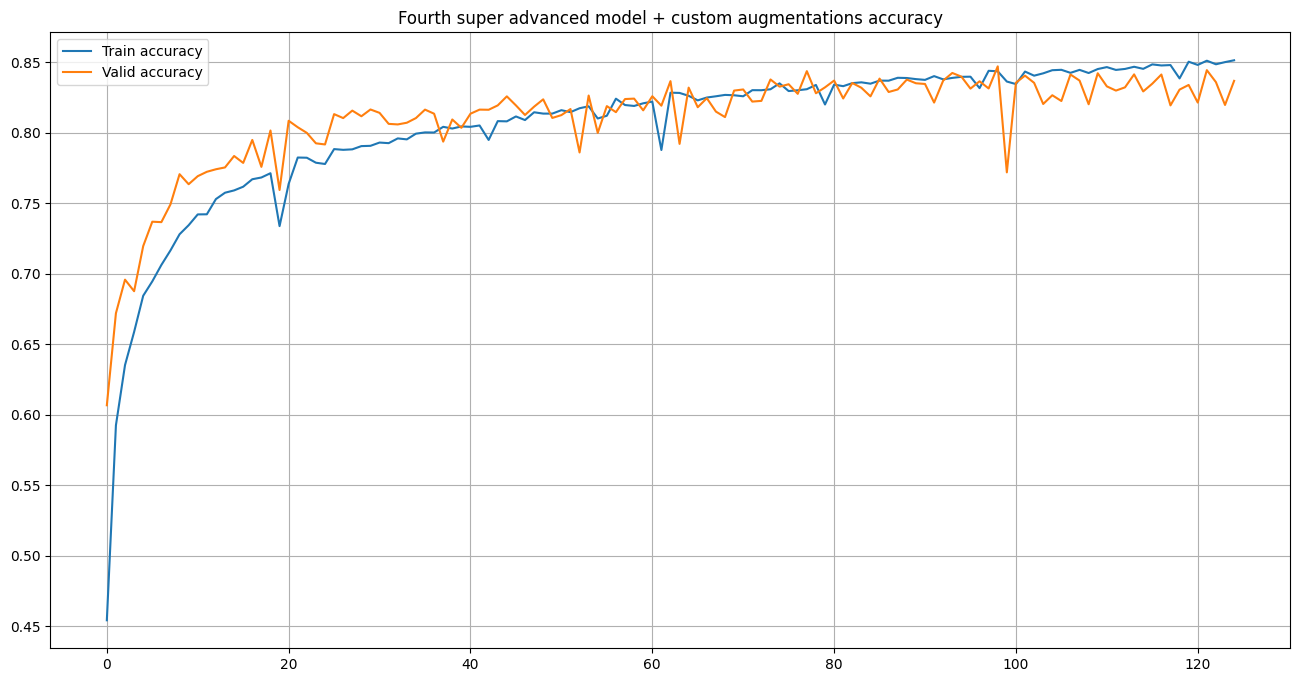

[0.6066, 0.6719, 0.6957, 0.6875, 0.7195, 0.7368, 0.7365, 0.7491, 0.7705, 0.7634, 0.7691, 0.7722, 0.774, 0.7753, 0.7834, 0.7785, 0.7948, 0.7757, 0.8015, 0.7593, 0.8084, 0.8038, 0.7998, 0.7924, 0.7916, 0.8131, 0.8103, 0.8156, 0.8116, 0.8164, 0.814, 0.8062, 0.8058, 0.807, 0.8103, 0.8163, 0.8134, 0.7936, 0.8093, 0.8034, 0.8134, 0.8163, 0.8162, 0.8193, 0.8257, 0.8193, 0.8125, 0.8184, 0.8236, 0.8104, 0.8124, 0.8167, 0.7859, 0.8263, 0.7998, 0.8188, 0.8145, 0.8238, 0.8241, 0.8158, 0.8258, 0.8191, 0.8365, 0.792, 0.8319, 0.818, 0.8244, 0.8149, 0.811, 0.8298, 0.8306, 0.822, 0.8225, 0.8377, 0.8326, 0.8343, 0.8275, 0.8436, 0.8279, 0.8321, 0.8369, 0.8242, 0.8352, 0.8318, 0.8257, 0.8383, 0.8288, 0.8306, 0.8376, 0.835, 0.8345, 0.8213, 0.8369, 0.8423, 0.8397, 0.8312, 0.8364, 0.8313, 0.847, 0.7718, 0.8354, 0.8404, 0.8353, 0.8203, 0.8265, 0.8224, 0.8412, 0.8369, 0.8201, 0.8421, 0.8328, 0.8298, 0.8321, 0.8413, 0.8292, 0.8347, 0.8412, 0.8193, 0.8305, 0.8338, 0.8213, 0.8443, 0.8358, 0.8196, 0.8367]
complete

In [13]:
whole_train_valid_cycle(model, 125, 'Fourth super advanced model + custom augmentations')

In [14]:
@torch.inference_mode()
def predict_tta(model: nn.Module, loader: DataLoader, device: torch.device, iterations: int = 2):

    model.eval()
    model.to('cpu')

    with torch.no_grad():
        predictions=[]


    for i in range(0, iterations):

        single_prediction = []

        for x,y in loader:
            x, y = x.to('cpu'), y.to('cpu')

            output = model(x)

            single_prediction.append(output)

        predictions.append(torch.vstack(single_prediction))
    
    all_predictions = torch.stack(predictions)

    all_predictions = all_predictions.mean(dim=0)

    return torch.argmax(all_predictions, dim=1)

In [15]:
predictions = predict_tta(model, valid_loader, device)

In [16]:
torch.save(predictions, 'predictions_step_5_7.pt')